# <font color='#28B463'>REPEATED HOLD-OUT

<br>

## <font color='#28B463'>Introduction

<br>
One way to obtain a more robust performance estimate that is less variant to how we split the data into training and test sets is to repeat the holdout method $n$ times with different random seeds and compute the average performance over these $n$ iterations. 

<br>
This repeated holdout procedure (sometimes also called Monte Carlo Cross-Validation), provides a better estimate of how well our model may perform on a random test set, and it can also give us an idea about our model stability : how the model produced by a learning algorithm changes with different training set splits.


In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
import sklearn.metrics as mtr

import utilcompute as uc
from pprint import pprint


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = uc.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

train_perc = 0.8
delimiter = int(len(df) * train_perc)
seeds = range(1, 100 + 1)

print('train set size   : ', delimiter)
print('test  set size   : ', (len(df) - delimiter))
print()
print('seeds : {0} ... {1}'.format(list(seeds)[:3], list(seeds)[-3:]))


train set size   :  120
test  set size   :  30

seeds : [1, 2, 3] ... [98, 99, 100]


In [10]:
scores_train = []
scores_test = []

for (s_index, s) in enumerate(seeds):
    np.random.seed(s)
    df_shuffled = df.reindex(np.random.permutation(df.index))    
    
    train = df_shuffled[:delimiter]
    test = df_shuffled[delimiter:]
    
    #if (s_index == 0):
    #    print('df_shuffled indices : {0} ... {1}'.format(df_shuffled.index.values[:3], df_shuffled.index.values[-3:]))     
    #    print('train set/fold size : ', len(train))
    #    print('test  set/fold size : ', len(test))
    #    print()
    #    print('train : {0} - {1}'.format(train.index.values.tolist()[:3], train.index.values[-3:]))
    #    print('test  : {0} - {1}'.format(test.index.values.tolist()[:3], test.index.values[-3:]))
    #    print()
    
    #model = lm.LogisticRegression()
    model = nbr.KNeighborsClassifier(n_neighbors = 5)
    model.fit(train[features], train[target])
    
    y_pred_train = model.predict(train[features])
    y_pred_test = model.predict(test[features])
    
    #metrics_train = uc.compute_classification_metrics(y = train[target], y_pred = y_pred_train)
    #metrics_test = uc.compute_classification_metrics(y = test[target], y_pred = y_pred_test)
    
    acc_train = mtr.accuracy_score(y_true = train[target], y_pred = y_pred_train, normalize = True, sample_weight = None)
    acc_test = mtr.accuracy_score(y_true = test[target], y_pred = y_pred_test, normalize = True, sample_weight = None)
    
    #scores_train.append(1 - metrics_train['ACCURACY'])
    #scores_test.append(1 - metrics_test['ACCURACY'])
    
    scores_train.append(1 - acc_train)
    scores_test.append(1 - acc_test)
    

In [11]:
print()
print('train | err mean : ', np.mean(scores_train))
print('train | err std  : ', np.std(scores_train))

print()
print('test  | err mean : ', np.mean(scores_test))
print('test  | err std  : ', np.std(scores_test))



train | err mean :  0.0378333333333
train | err std  :  0.0123839053255

test  | err mean :  0.0496666666667
test  | err std  :  0.0344786568442


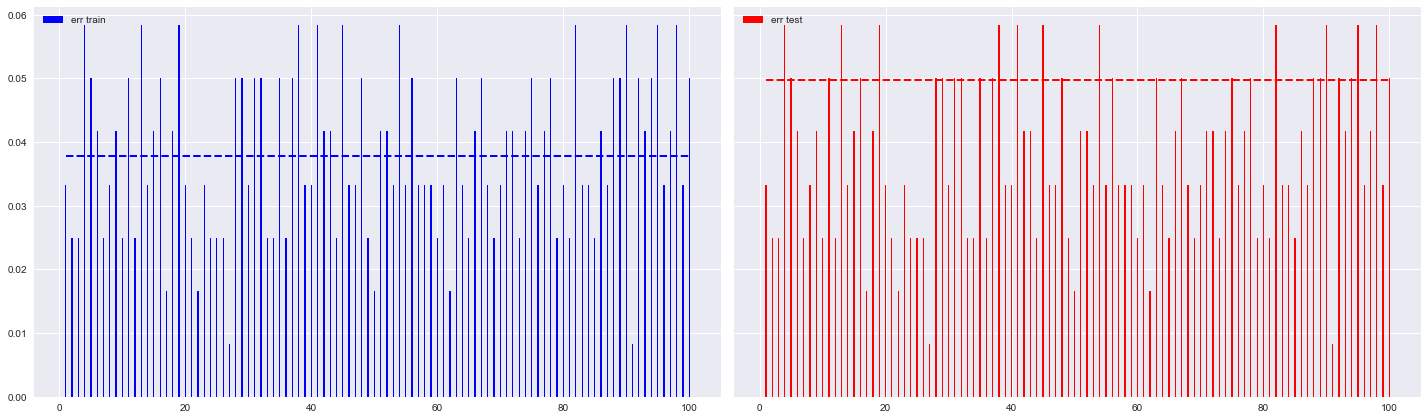

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 6), sharey = True) 

width = 0.2
tick_label = np.array( list(range(1, 101 + 1, 10)) ) -1
axs[0].bar(left = np.array(seeds), height = scores_train, width = width, align = 'center', color = 'blue', label = 'err train')
axs[0].plot( (min(seeds), max(seeds)), (np.mean(scores_train), np.mean(scores_train)), color = 'blue', lw = 2, linestyle = '--')
axs[0].legend(loc='best')

axs[1].bar(left = np.array(seeds), height = scores_train, width = width, align = 'center', color = 'red', label = 'err test')
axs[1].plot( (min(seeds), max(seeds)), (np.mean(scores_test), np.mean(scores_test)), color = 'red', lw = 2, linestyle = '--')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

## <font color='#28B463'>Considerations

<br>
<b>The distribution of data points which happen to fall in the training or test set obviously has a huge effect on the model stability</b>, but why ? We can analyze this behaviour in terms of sampling.

<br>
One of the fundamental assumptions we make every time we run a classification (or prediction) algorithm is that our samples are IID, which means that all samples have been drawn from the same probability distribution and are statistically independent from each other.

<br>
We also typically assume that the original dataset is a representative sample of the true population, further sub-sampling without replacement alters the statistics (mean, proportion, and variance) of the sub-samples; the degree to which sub-sampling without replacement affects the statistics of a sample is inversely proportional to the size of the sample.

<br>
What does simple random sampling have to do with hold out validation ? <br>
Since we are not sampling, at least not in this notebook, the logic of simple random sampling applies by analogy; just like the points distribution of the sub-samples depend on which points are selected, <b>the distribution of features and target within training and test sets (and therefore the properties of these two datasets, along with prediction accuracy) vary widely, depending on which points happen to fall in the former or in the latter</b>. 

<br>
<b>In repeated hold-out validation</b> we still have iterations with non-representative or skewed distributions of the data points, but <b>by averaging over the totality of our iterations we obtain a more robust estimate of the expected classification (or regression) error. The average value of our error metric is more reliable because it has been subject to a broader range of possible train-test splits.</b>

<br>
<font color='#28B463'><b>Further questions/issues</b></font> :

<br>
<ul style="list-style-type:square">
    <li>
        the different test (or training) sets may overlap; the repeated use of samples for testing results in performance
        estimates that become dependent between rounds, this dependence can be problematic for statistical comparisons
    </li>
    <br>
    <li>
        some data points may never appear in training (or test) set (inherited from hold-out validation)
    </li>
    <br>
    <li>
        the size we choose for the test set (inherited from hold-out validation)
    </li>
</ul>

<br>
<font color='#28B463'><b>Note</b></font> : see Stratified Hold-Out


## <font color='#28B463'>References

<br>
<ul style="list-style-type:square">
    <li>
        Sebastian Raschka - Model evaluation, model selection, and algorithm selection in machine learning - Part II <br>
        https://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html
    </li>
</ul>
